In [1]:
# IMPORT YOUR LIBRARIES HERE

# Import standard libraries
import os
os.environ["OMP_NUM_THREADS"] = '1'
import pandas as pd
import numpy as np
from collections import defaultdict
import io
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Clustering import
from sklearn.cluster import KMeans  # K-Means algorithm
from sklearn.cluster import AgglomerativeClustering  # Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage # dendogram visualization

# Import from mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Import from surprise library
from surprise import Dataset
from surprise import get_dataset_dir
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split 
from surprise.model_selection import cross_validate, GridSearchCV

# Assignment 2

Welcome to the second assignment! 

You will have to implement clustering, association rules, and recommender systems algorithms, applying these methods to: 
- explore the similarities within groups of people watching movies (clustering analysis)
- discover the relations between movies genre (association rules)
- recommend movies to users (recommender system)

We will use the MovieLens dataset, which contains movie ratings collected from the MovieLens website by the [GroupLens](https://grouplens.org/) research lab.

Source: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

Once you are done you have to submit your notebook here: 
[https://moodle.epfl.ch/mod/assign/view.php?id=1247726](https://moodle.epfl.ch/mod/assign/view.php?id=1247726)

If there is need for further clarifications on the questions, after the assignment is released, we will update this file, so make sure you check the git repository for updates.

Good luck!

## Clustering analysis: similarities between people (10 points)

In this section, you will try to form clusters of individuals based on their preferences regarding movie genres. You will use a transformed version of the MovieLens dataset containing, for a selection of users:
- their average rating of all science fiction movies they rated,
- their average rating of all comedy movies they rated.

Better understanding the differences in people's tastes can help improve the design of recommender systems, for instance for the creation of the user neighborhood. Ok, let's start!

- Load the data in a dataframe. The url link is provided below. Display the first 10 observations.

In [2]:
url_clustering = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/ratings_clustering.csv'

# YOUR CODE HERE
df_clustering = pd.read_csv(url_clustering)
df_clustering.head(10)

,avg_scifi_rating,avg_comedy_rating
0,3.50,2.71
1,2.56,2.64
2,2.00,3.20
3,3.18,2.83
4,3.00,3.90
5,2.33,3.20
6,3.00,3.63
7,2.30,3.40
8,3.11,3.39
9,2.85,2.47


- Plot a dendogram using "ward" as linkage method and "euclidean" as metric. 
- Based on the dendogram, how many clusters do you think is optimal? Briefly justify your answer.

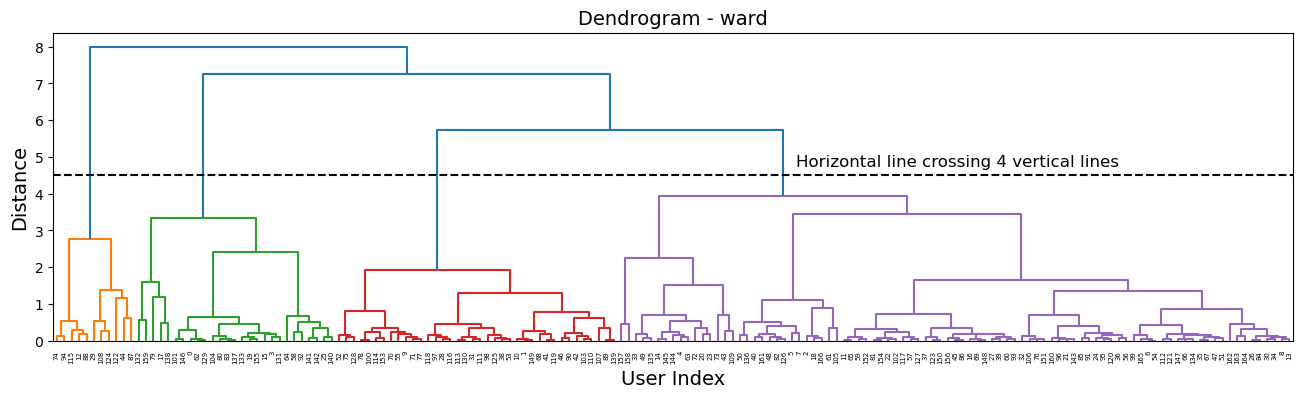

In [3]:
# YOUR CODE HERE

# Linkage between users
Z = linkage(df_clustering, method = 'ward', metric = 'euclidean')

# Plot dendogram
plt.figure(figsize=(16, 4))
dendrogram(Z)
plt.hlines(y=4.5,xmin=0,xmax=2000,colors='k',linestyles='--')
plt.text(x=1000,y=4.75,s='Horizontal line crossing 4 vertical lines',fontsize=12)
plt.title('Dendrogram - ward', fontsize=14)
plt.xlabel('User Index', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.show()

- Implement the Elbow method to determine the optimum number of cluster for K-Means algorithm (use `random_state=17` as parameter of K-Means). 
- Based on the Elbow method, how many clusters do you think is optimal? Briefly justify your answer.

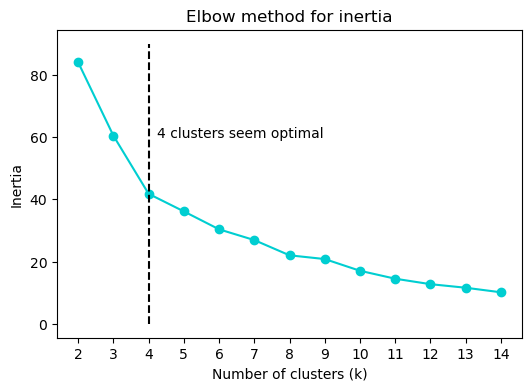

In [4]:
# YOUR CODE HERE

X = df_clustering[['avg_scifi_rating','avg_comedy_rating']].values

inertias = []
nbr_clusters = range(2,15)

for i in nbr_clusters:
    km = KMeans(n_clusters=i, random_state=17, n_init='auto').fit(X)  # Create and fit model
    inertias.append(km.inertia_)     # Store inertia

# Plot
plt.figure(figsize=(6, 4))
plt.plot(nbr_clusters, inertias, '-o', color='darkturquoise')
plt.vlines(x=4,ymin=0,ymax=90,linestyles='--', color='k')
plt.text(x=4.25,y=60,s='4 clusters seem optimal', fontsize=10)
plt.xticks(nbr_clusters)
plt.title('Elbow method for inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

- Implement (train) a K-Means algorithm with the number of clusters of your choice. Use `random_state=17` as parameter.

In [5]:
# YOUR CODE HERE

# KMeans model with 4 clusters
model_kmeans = KMeans(n_clusters=4, random_state=17, n_init='auto') 

# Fit the model on X
model_kmeans.fit(X)                                                   

KMeans(n_clusters=4, n_init='auto', random_state=17)

- Implement (train) a hierarchical algorithm with the same number of clusters as for the K-Means model. Use "ward" as linkage method and "euclidean" as metric/affinity 

In [6]:
# YOUR CODE HERE

# Hierarchical clustering with 4 clusters
model_hc = AgglomerativeClustering(n_clusters=4,
                                  metric='euclidean', 
                                  linkage='ward') 

# Fit the model on X
model_hc.fit(X)

AgglomerativeClustering(metric='euclidean', n_clusters=4)

- Create a figure consisting of two subplots:
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your KMeans model. Add the cluster centers to your plot. Label your clusters with the name of your choice (e.g., "Comedy aficionado").
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your hierarchical algorithm model. Label your clusters with the name of your choice.
- How do your models compare?

In [7]:
# YOUR CODE HERE

# Add columns to our dataframe with the cluster labels
df_clustering['cluster knn'] = model_kmeans.labels_
df_clustering['cluster hc'] = model_hc.labels_

# Adjust cluster hc to obtain the same cluster labels as cluster knn when the prediction is the same
cluster_dict = {0:3, 1:1, 2:2, 3:0}
df_clustering['cluster hc'] = df_clustering['cluster hc'].map(cluster_dict)

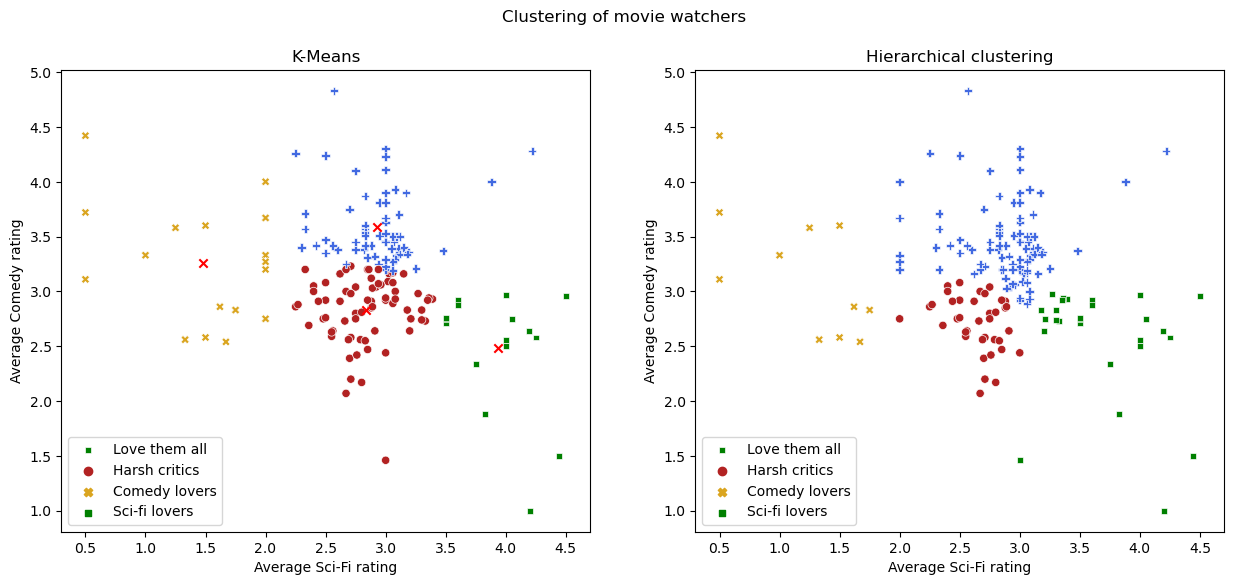

In [8]:
# YOUR CODE HERE

# We will do two subplot, one for K-Means, the other for hierarchical clustering
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

fig.suptitle("Clustering of movie watchers")

# K-Means
ax[0].set_title("K-Means")
ax[0].set_xlabel("Average Sci-Fi rating")
ax[0].set_ylabel("Average Comedy rating")
sns.scatterplot(data = df_clustering, 
                x='avg_scifi_rating', 
                y='avg_comedy_rating',  
                hue='cluster knn',                                             # Color by cluster
                palette = ['firebrick', 'goldenrod', 'green', 'royalblue'],    # Choice of colors
                style = 'cluster knn',                                         # Style of markers by cluster
                ax = ax[0])                                                    # Position
# Cluster centers
ax[0].scatter(model_kmeans.cluster_centers_[:, 0],  # x-coordinates of cluster centroids
              model_kmeans.cluster_centers_[:, 1],  # y-coordinates of cluster centroids
              c="red",                              # color of centroids
              marker='x')                           # marker of centroids
ax[0].legend(labels=['Love them all', 'Harsh critics', 'Comedy lovers', 'Sci-fi lovers'])  # Label legend

# Hierarchical clustering
ax[1].set_title("Hierarchical clustering")
ax[1].set_xlabel("Average Sci-Fi rating")
ax[1].set_ylabel("Average Comedy rating")
sns.scatterplot(data = df_clustering, 
                x='avg_scifi_rating', 
                y='avg_comedy_rating', 
                hue='cluster hc',                                              # Color by cluster
                palette = ['firebrick', 'goldenrod', 'green', 'royalblue'],    # Choice of colors
                style = 'cluster hc',                                          # Style of markers by cluster
                ax = ax[1])                                                    # Position
ax[1].legend(labels=['Love them all', 'Harsh critics', 'Comedy lovers', 'Sci-fi lovers'])  # Label legend

plt.show()

## Association Rules: association between movie genres (10 points)

You will now pursue your analysis, but this time trying to dig out information about movies. More precisely, you will search for matches between film genres using association rules. We try to understand, for instance, how likely it is that a film is both drama and action. This information can be interesting for film producers who may either want to produce something similar to the established norm: if most drama films are also action, perhaps the new action-drama film would be equally appreciated, or quite to the contrary try a new combination of genres which is more rare to find.

- Load the data in a dataframe. The url link is provided below. 
- Display the first 10 observations. 
- Print the unique values of genres from the first column. 
- How many unique genres does the first column contain? 
- How many movies does the dataframe contains?

In [ ]:
url_association_rules = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/movies_assoc_rules.csv'

# YOUR CODE HERE

df_association = pd.read_csv(url_association_rules, sep=',')
display(df_association.head(10))

# Unique items (genres) in first column:
items = df_association['0'].unique()
# Print genres - we use the join method to print items one by one:
print(f'Our dataset contains {len(items)} genres: '
      +', '.join(items))

# Print number of movies
print(f'Our dataset contains {len(df_association.index)} movies.')

- Preprocessing: as seen during the lab, convert the dataset using a `Transaction Encoder` from the `mlextend` module so that the dataset is reorganised in columns of unique genres. Rows should contain only True or False boolean values according to whether a film was considered as belonging to a genre column or not. Check that you have the correct dimensions.

In [ ]:
# YOUR CODE HERE

# Convert dataframe to list of list
genres_list = df_association.values.tolist()

# Remove NaNs with list comprehensions
genres_list_cleaned = [[x for x in y if str(x) != 'nan'] for y in genres_list]

# Create instance of Encoder
te = TransactionEncoder()

# Fit encoder and transform our list
genres_list_encoded = te.fit(genres_list_cleaned).transform(genres_list_cleaned)

# Create dataframe with results
genres_encoded = pd.DataFrame(genres_list_encoded, columns=te.columns_)

display(genres_encoded.head())
shape_genres_encoded = genres_encoded.shape
print(f'Our dataset contains {shape_genres_encoded[0]} movies and {shape_genres_encoded[1]} unique genres.')

- Frequent itemsets: using the Apriori algorithm to find the frequent itemsets with minimum support of 0.01. There is no condition on the maximum length of an itemset. 
- How many itemsets did the apriori algorithm return above (for min_support=0.01)? 
- What are the 10 itemsets with the largest support (you can directly display a dataframe with the 10 itemsets and their support)?

In [ ]:
# YOUR CODE HERE

# Apriori algorithm
freq_items = apriori(genres_encoded, min_support=0.01, use_colnames=True)

# Itemset with support >0.01
print(f'There are {len(freq_items)} itemsets with minimum support of 0.01.')

# Dataframe with top 10 itemsets and their support
display(freq_items.sort_values(by="support", ascending=False).head(10))

- Mining for association rules: using the frequent items identified above, find association rules with a minimum confidence of 0.45 and order them by decreasing value of lift.
- Discuss the following statements (true or false with 1-2 lines justification)
    - Animation films are associated with Children.  
    - If a film has the genre Musical, then it is also a Comedy.
    - If War then Drama is the asociation rule with the highest confidence.  

In [ ]:
# YOUR CODE HERE

# Generate rules
rules = association_rules(freq_items, metric="confidence", min_threshold=0.45)

# Rules sorted by lift
rules.sort_values(by="lift", ascending=False)

*Animation films are associated with Children* **True**: The association Animation $\Rightarrow$ Children has a sufficient confidence and the highest lift. In other words, Children frequently occurs with Animation, and the rule is interesting according to the lift metrics.

*If a film has the genre Musical, then it is also a Comedy* **False**: An association rule does **not** indicate a causal link. There could be movies that are Musical and not Comedy. 

*If War then Drama is the asociation rule with the highest confidence* **True**. To see that, we can sort by confidence.  

## Recommender systems: item-based recommender system (10 points)

In the walkthrough, we have implemented a user-to-user collaborative filtering algorithm (from scratch and using using Surprise library), i.e., our recommendations were based on the ratings of users with similar tastes. In this assignment, you will implement an **item-to-item** collaborative filtering algorithm, i.e., the recommendations will be based on the set of movies that users like. Do not worry, you won't have to implement the algorithm from scratch and instead can rely on the [Surprise library](http://surpriselib.com/). 

- As in the walkthrough, load the *built-in* `ml-100k` from the Surprise library.

In [ ]:
# YOUR CODE HERE

# Load data
data_movies = Dataset.load_builtin('ml-100k')

- Use GridSearchCV to find the best number of neighbors (k) for a KNNWithMeans **item-based** algorithm, with the following parameters:
    - options for k: `[10, 20, 30, 40, 50]`
    - `'sim_options': {'name': ['pearson'], 'user_based': [???]}` Here you have to replace `???` with the appropriate value...
    - root-mean-square-error (RMSE) as measures,
    - 5 cross-validation folds,
    - other parameters: `refit=True, joblib_verbose=2, n_jobs=-1`
- What is the optimal k for which GridSearchCV returned the best RMSE score? 
- What is the RMSE score for the optimal k?

In [ ]:
# YOUR CODE HERE

# Parameter grid
# IMPORTANT: 'user_based': [False] for an item-based algorithm!
param_grid={'k': [10, 20, 30, 40, 50], 
            'sim_options': {'name': ['pearson'], 'user_based': [False]}}

# Initiate model
KNN_grid_search = GridSearchCV(KNNWithMeans, param_grid=param_grid, 
                               measures=['RMSE'], cv=5,
                               refit=True, joblib_verbose=2, n_jobs=-1)

# Fit model
KNN_grid_search.fit(data_movies)

# Best model
print('Best parameter:', KNN_grid_search.best_params)
print('Best RMSE score: ', KNN_grid_search.best_score)

- Using the Surprise library, split your dataset between training and test set. As parameters, use `test_size=0.2, random_state=12`
- Fit a KNNWithMeans algorithm using the best k value retrieved above. As other parameters, use:
    - `min_k=1`
    - `sim_options = {'name': 'pearson','user_based': ???}`
    - `verbose=False`
- Predict ratings on the test set using your algorithm

In [ ]:
# YOUR CODE HERE

# Split between training and test set
trainset, testset = train_test_split(data_movies, test_size=0.2, random_state=12)

# Define options
# IMPORTANT: 'user_based': False for an item-based algorithm!
sim_options = {'name': 'pearson','user_based': False}

# Create instance of KNNWithMeans with k=50
knn_means = KNNWithMeans(k=50, min_k=1, sim_options=sim_options, verbose=False)

# Fit model
knn_means.fit(trainset)

# Predict ratings on test set
predictions = knn_means.test(testset)

- Use the helper function below to identify the best 10 films for all users
- Find the top 10 predictions for user 169 (you should return the titles of the movies)

In [ ]:
def read_item_names():
    '''Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    '''

    file_name = get_dataset_dir() + '/ml-100k/ml-100k/u.item'
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list) # This is used to group a sequence of key-value pairs into a dictionary of lists
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [ ]:
# YOUR CODE HERE

# Get top 10 movies for all users
top_n = get_top_n(predictions, n=10)

# Read the mappings row id <-> movie name
rid_to_name, name_to_rid = read_item_names()

# Print the recommended items for user id 169
uid = '169'
user_ratings = top_n[uid]
recommended_items = [iid for (iid, _) in user_ratings]
print(f'Recommended items for user id {uid}: ',', '.join(recommended_items))

# Convert ids into movie titles
item_names = [rid_to_name[rid]
              for rid in recommended_items]
print(f'\nRecommended movies for user id {uid}: ', ', '.join(item_names))

- Plot the precision at rank k and the recall at rank k on the same figure, for k between 0 and 20, and a relevance threshold of 3.75
- Plot the precision-recall curve

*You can, but do not have to, rely on the function(s) used in the lab (i.e., copying the code of the function(s))*

In [ ]:
# YOUR CODE HERE

def precision_recall_at_k(predictions, k=10, threshold=3.75):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [ ]:
# Compute precision and recall for k between 0 and 20
precision = []
recall = []
for k in range(21):
    # rating > 3.75 = relevant, rating < 3.75 = irrelevant
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.75)
    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

In [ ]:
# Plot precision at rank k and recall at rank k
plt.figure(figsize=(6, 4))
plt.plot(range(21), recall, 'o-', label="Recall")
plt.plot(range(21), precision, 'o-', label="Precision")
plt.legend()
plt.xticks(range(21))
plt.xlabel('k')
plt.title("Precision and recall at rank k for item-based KNN")
plt.show();

In [ ]:
# Plot precision-recall curve
plt.figure(figsize=(4, 4))
plt.step(recall, precision, color='b', where='post', label ='KNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for item-based KNN')
plt.show()

Congrats, you are done with the assignment!